In [1]:
# hide
%reload_ext autoreload
%autoreload 2

In [12]:
from dataFunction import *
from clientClassDP import *
import diffprivlib.models as dp
import numpy as np
import copy

In [3]:

cleveland = "FL_HE_2/processed.cleveland.data"
switzerland = "FL_HE_2/processed.switzerland.data"
va = "FL_HE_2/processed.va.data"
hungarian = "FL_HE_2/reprocessed.hungarian.data"
cleveland_df, switzerland_df, va_df, hungarian_df = import_data(cleveland, switzerland, va, hungarian)
df_dict ={
    'Cleveland': cleveland_df,
    'Switzerland': switzerland_df,
    'VA Long Beach': va_df,
    'Hungary': hungarian_df        
    }



In [4]:
clients = []
glob_model = dp.LogisticRegression(epsilon=float("inf"), data_norm=1e5)
for i in list(df_dict.keys()):
    df = df_dict.get(i)
    df_dict[i] = new_df(df)
    location_data = new_df(df)
    y = location_data.HeartDisease
    location_data = location_data.drop(columns="HeartDisease")
    cat_feat = ['ChestPainType', 'RestingECG', 'ST_Slope']
    location_data = make_dummies(location_data, cat_feat)
    numeric_feature_names = ['Age', 'MaxHR', 'RestingBP',  'Cholesterol', 'Oldpeak']
    for j in numeric_feature_names:
        if location_data[j].std() != 0: 
            location_data[j] = (location_data[j] - location_data[j].mean()) / location_data[j].std()
    x = location_data
    client_model = copy.deepcopy(glob_model)
    lr = 3
    lr_decay = 1
    clients.append(Client(i, x, y, cat_feat, client_model))



In [5]:
X_test = clients[0].X_test 
y_test = np.ravel(clients[0].y_test)
X_train = clients[0].X_train
y_train = np.ravel(clients[0].y_train)

In [6]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(solver="lbfgs")
clf.fit(X_train, y_train)
baseline = clf.score(X_test, y_test)
print("Non-private test accuracy: %.2f%%" % (baseline * 100))

Non-private test accuracy: 73.77%


In [7]:

dp_clf = dp.LogisticRegression()
dp_clf.fit(X_train, y_train)
print("Differentially private test accuracy (epsilon=%.2f): %.2f%%" % 
     (dp_clf.epsilon, dp_clf.score(X_test, y_test) * 100))

Differentially private test accuracy (epsilon=1.00): 34.43%


/Users/romyho/Documents/Master_Econometrie/Thesis/Thesis_FL_Ectrie/thesis_fl/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "


In [66]:
dp_clf2 = dp.LogisticRegression(epsilon=float("inf"), data_norm=1e5)
dp_clf2.fit(X_train, np.ravel(y_train))
print("Agreement between non-private and differentially private (epsilon=inf) classifiers: %.2f%%" % 
     (dp_clf.score(X_test, dp_clf2.predict(X_test)) * 100))

Agreement between non-private and differentially private (epsilon=inf) classifiers: 49.18%


In [67]:
accuracy = []
epsilons = np.logspace(-3, 1, 500)

for eps in epsilons:
    dp_clf = dp.LogisticRegression(epsilon=eps, data_norm=100)
    dp_clf.fit(X_train, y_train)
    accuracy.append(dp_clf.score(X_test, y_test))

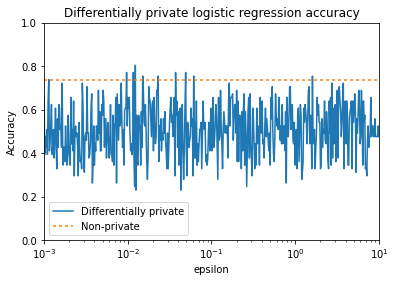

In [43]:
import matplotlib.pyplot as plt
plt.semilogx(epsilons, accuracy, label="Differentially private")
plt.plot(epsilons, np.ones_like(epsilons) * baseline, dashes=[2,2], label="Non-private")
plt.title("Differentially private logistic regression accuracy")
plt.xlabel("epsilon")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xlim(epsilons[0], epsilons[-1])
plt.legend(loc=3)
plt.show()

In [45]:
dp_clf.coef_

array([[-214.83433617, -308.91374354,  139.33140314, -209.7192263 ,
        -236.79542833,  -99.23264994,   90.92674494,  186.22150942,
        -324.19631152,  120.81294269, -901.6103239 ,  100.54557639,
         120.05532649,  344.61045433, -121.74917681, 1219.02829493,
         323.11231197,   16.04974425]])

In [13]:
loss_train = []
net_best = None
best_acc = None
best_epoch = None
EPOCHS = 2
results = []
min_loss_client = []
for iter in range(EPOCHS):
    loss_locals = []
    client_state_dicts = []
    for client in clients:
        model, loss = client.train()
        print(loss)
        
        # loss_locals.append(copy.deepcopy(loss))
        # min_loss_client.append(min(loss))

    # enrypted_state_dicts = encrypt_state_dicts(copy.deepcopy(client_state_dicts), ctx_eval)
    # averaged_encrypted_state_dict = average_state_dict(enrypted_state_dicts)
    # decrypted_state_dicts = decrypt_state_dicts(averaged_encrypted_state_dict)
    # glob_model.load_state_dict(decrypted_state_dicts)

    # loss_avg = sum(min_loss_client) / len(min_loss_client)
    # loss_train.append(loss_avg)    
    # print(loss_avg)    
        
    # acc_test, loss_test =  accuracy_loss_LR(glob_model,validation_X_set, validation_y_set)

#     print('Round {:3d}, Average loss {:.3f}, Test loss {:.3f}, Test accuracy: {:.2f}'.format(
#         iter, loss_avg, loss_test, acc_test))


#     if best_acc is None or acc_test > best_acc:
#         net_best = copy.deepcopy(glob_model)
#         best_acc = acc_test
#         best_epoch = iter

#     results.append(np.array([iter, loss_avg, loss_test, acc_test, best_acc]))
#     final_results = np.array(results)
#     final_results = pd.DataFrame(final_results, columns=['epoch', 'loss_avg', 'loss_test', 'acc_test', 'best_acc'])

# print('Best model, iter: {}, acc: {}'.format(best_epoch, best_acc))    
    

[0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0.
 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0.
 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0.]
0.7377049180327869
[0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0.
 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0.
 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0.]
0.7377049180327869
[0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0.
 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0.
 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0.]
0.7377049180327869
[0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0.
 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0.
 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0.]
0.7377049180327869
[0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0.
 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0.
 1. 0. 1. 0. 0. 0. 1. 0. 0. 0.